# Vision Transformer

## Import Libraries

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

#from vit_pytorch.efficient import ViT


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [4]:
# Training settings
batch_size = 64
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [16]:
device = 'cuda'

## Load Data

In [140]:

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

## Random Plots

In [58]:
image.numpy().transpose(1,2,0).shape

(32, 32, 3)

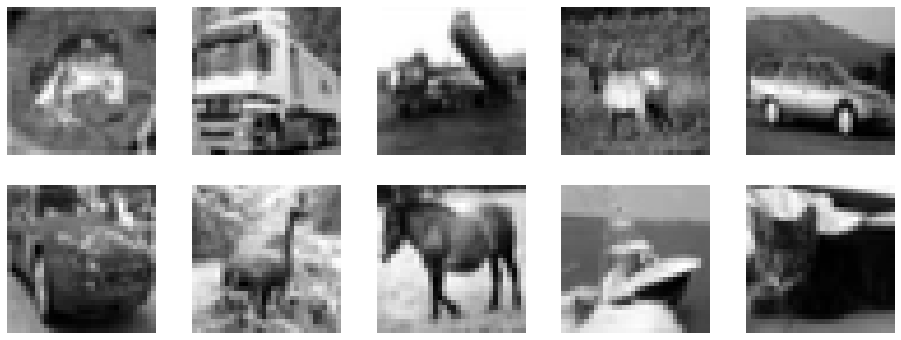

In [61]:

# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),cmap='gray')
    plt.axis('off');

## Split

In [62]:
train_loader.dataset.__len__()

50000

In [63]:
print(f"Train Data: {train_loader.dataset.__len__()}")
print(f"Test Data: {test_loader.dataset.__len__()}")


Train Data: 50000
Test Data: 10000


### Visual Transformer

In [64]:
import sys
sys.path.append('../vit_pytorch/')

from vit import ViT

In [65]:
from recorder import Recorder # import the Recorder and instantiate
rec = Recorder()

In [101]:
model = ViT(
    dim=128,
    image_size=32,
    patch_size=8,
    num_classes=10,
  #  transformer=efficient_transformer,
    channels=1,
    depth = 2, heads=3, mlp_dim=32
).to(device)

### Training

In [102]:
from madgrad import MADGRAD

In [103]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = MADGRAD(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [104]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader: # interchangable with val for this toy experiment
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / test_loader.dataset.__len__()
            epoch_val_loss += val_loss / test_loader.dataset.__len__()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.2460 - acc: 0.1710 - val_loss : 0.0021 - val_acc: 0.0002



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.0573 - acc: 0.2656 - val_loss : 0.0020 - val_acc: 0.0003



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.9675 - acc: 0.2998 - val_loss : 0.0019 - val_acc: 0.0003



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.9054 - acc: 0.3226 - val_loss : 0.0019 - val_acc: 0.0003



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.8615 - acc: 0.3384 - val_loss : 0.0018 - val_acc: 0.0003



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.8302 - acc: 0.3503 - val_loss : 0.0018 - val_acc: 0.0003



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.8058 - acc: 0.3579 - val_loss : 0.0018 - val_acc: 0.0004



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.7850 - acc: 0.3657 - val_loss : 0.0018 - val_acc: 0.0004



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.7674 - acc: 0.3731 - val_loss : 0.0018 - val_acc: 0.0004



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.7542 - acc: 0.3780 - val_loss : 0.0018 - val_acc: 0.0004



In [121]:
test_loader.dataset.__len__()

10000

In [122]:
preds = model(data, rec = rec) # pass in the recorder


In [123]:
(preds.argmax(dim=1) == label).float().mean()


tensor(0.3920, device='cuda:0')

In [124]:
j = 4
attn_mat = rec.attn[j].cpu()
im = data[j][0].cpu()

In [125]:
attn_mat.shape

torch.Size([2, 3, 17, 17])

In [126]:
attn_mat = torch.mean(attn_mat, dim=1) # average across heads 


In [127]:
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(attn_mat.size(1))
aug_att_mat = attn_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

In [128]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]



In [129]:
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# combines all the different layers which apply attention. 

In [130]:
import cv2

In [131]:
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (32,32))[..., np.newaxis]
result = (mask * im.unsqueeze(2).numpy()).astype("uint8")

In [132]:
im.unsqueeze(2).numpy().shape

(32, 32, 1)

In [133]:
im.shape

torch.Size([32, 32])

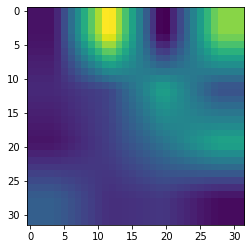

In [134]:
plt.imshow(mask)

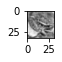

In [139]:
plt.figure(figsize=(.5,.5))
plt.imshow(im,cmap='gray')

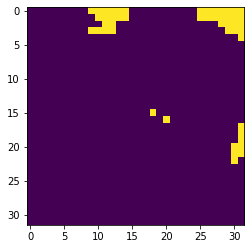

In [136]:
plt.imshow(result)

Looks pretty reasonable to me!


Not sure how to handle multiple channels yet  though... 